In [1]:
import pydot
import matplotlib.pyplot as plt
import time
import math
import random
from sklearn.manifold import MDS
import numpy as np
import plotly.graph_objs as go
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap

nodes [<pydot.core.Node object at 0x15a4af190>, <pydot.core.Node object at 0x15a4ac490>, <pydot.core.Node object at 0x15a51ca10>, <pydot.core.Node object at 0x159950a10>, <pydot.core.Node object at 0x15ef87350>, <pydot.core.Node object at 0x15ef86a90>, <pydot.core.Node object at 0x1620f85d0>, <pydot.core.Node object at 0x1597f51d0>, <pydot.core.Node object at 0x1596aa550>, <pydot.core.Node object at 0x15967a590>, <pydot.core.Node object at 0x15efe75d0>, <pydot.core.Node object at 0x1598fdad0>, <pydot.core.Node object at 0x1599a3490>, <pydot.core.Node object at 0x15a2a7e10>, <pydot.core.Node object at 0x15a51bd50>, <pydot.core.Node object at 0x15a545c90>, <pydot.core.Node object at 0x168c55e10>, <pydot.core.Node object at 0x15a5d3a90>, <pydot.core.Node object at 0x15a681f90>, <pydot.core.Node object at 0x15a6a76d0>, <pydot.core.Node object at 0x15b1f0210>, <pydot.core.Node object at 0x15b8de5d0>, <pydot.core.Node object at 0x15b838c90>, <pydot.core.Node object at 0x15a5d3690>, <pydot.co

/var/folders/pp/bdyt1jrd5w5d3twfkg227dtc0000gn/T/ipykernel_41076/3389298344.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='viridis', s=50)


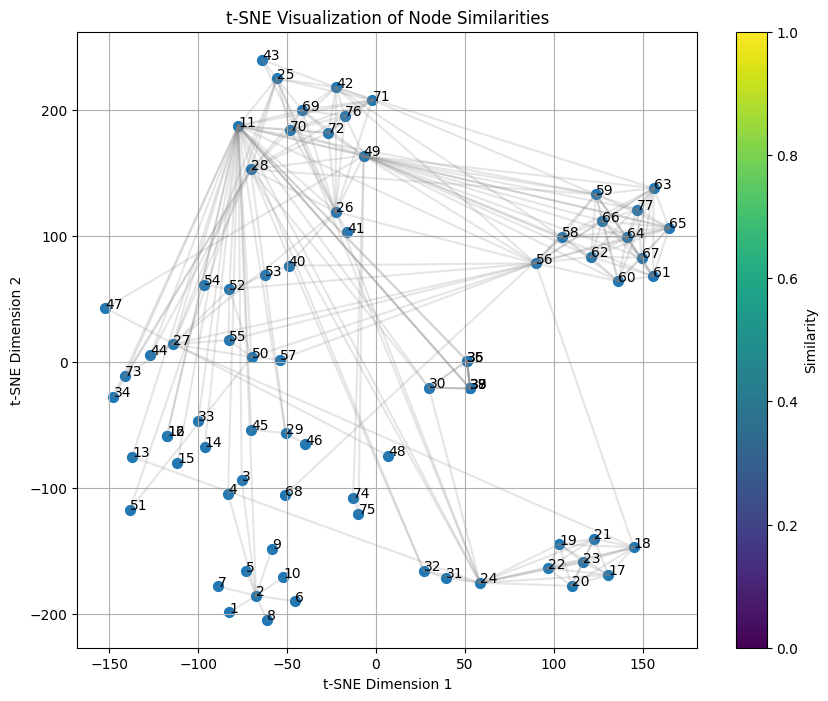

NameError: name 'labels' is not defined

NameError: name 'labels' is not defined

In [35]:
run 'Step6.ipynb'

# Miserables

In [36]:
nodes,edges,node_list,edge_list,weights = get_data_step6('Datasets/LesMiserables.dot')

In [37]:
def compute_similarity_matrix(node_list, edge_list, weights):
    edge_weights = {(u, v): weight for (u, v), weight in weights.items()}

    num_nodes = len(node_list)
    distances = np.zeros((num_nodes, num_nodes))
    for i, source in enumerate(node_list):
        for j, target in enumerate(node_list):
            if i != j:
                if (source, target) in edge_weights:
                    distances[i, j] = edge_weights[(source, target)]
                elif (target, source) in edge_weights:
                    distances[i, j] = edge_weights[(target, source)]
                else:
                    distances[i, j] = np.inf

    similarities = np.zeros((num_nodes, num_nodes))
    for u, v in edge_list:
        i = node_list.index(u)
        j = node_list.index(v)
        similarities[i, j] = 1 / (1 + distances[i, j])
        similarities[j, i] = similarities[i, j]  # Similarity matrix is symmetric

    np.fill_diagonal(similarities, 1) #diagonal 1

    return similarities

similarity_matrix = compute_similarity_matrix(node_list, edge_list, weights)

print("Similarity matrix:")
print("\t" + "\t".join(node_list))
for i in range(len(node_list)):
    print(node_list[i], "\t", end="")
    for j in range(len(node_list)):
        print("{:.2f}".format(similarity_matrix[i, j]), "\t", end="")
    print()

similarities = compute_similarity_matrix(node_list, edge_list, weights)


Similarity matrix:
	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	24	25	26	27	28	29	30	32	33	34	35	36	37	38	39	44	45	49	50	52	56	59	65	69	70	71	72	73	17	18	19	20	21	22	23	31	42	43	51	40	41	76	55	46	53	58	63	47	48	60	61	62	64	66	67	74	75	77	57	54	68
1 	1.00 	0.50 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	
2 	0.50 	1.00 	0.11 	0.09 	0.50 	0.50 	0.50 	0.50 	0.33 	0.50 	0.17 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0

Iteration 1: KL divergence = 0.29694777727127075
Iteration 2: KL divergence = 0.29694777727127075
Iteration 3: KL divergence = 0.29694777727127075
Iteration 4: KL divergence = 0.29694777727127075
Iteration 5: KL divergence = 0.29694777727127075
Iteration 6: KL divergence = 0.29694777727127075
Iteration 7: KL divergence = 0.29694777727127075
Iteration 8: KL divergence = 0.29694777727127075
Iteration 9: KL divergence = 0.29694777727127075
Iteration 10: KL divergence = 0.29694777727127075
Iteration 11: KL divergence = 0.29694777727127075
Iteration 12: KL divergence = 0.29694777727127075
Iteration 13: KL divergence = 0.29694777727127075
Iteration 14: KL divergence = 0.29694777727127075
Iteration 15: KL divergence = 0.29694777727127075
Iteration 16: KL divergence = 0.29694777727127075
Iteration 17: KL divergence = 0.29694777727127075
Iteration 18: KL divergence = 0.29694777727127075
Iteration 19: KL divergence = 0.29694777727127075
Iteration 20: KL divergence = 0.29694777727127075
Iteration

/var/folders/pp/bdyt1jrd5w5d3twfkg227dtc0000gn/T/ipykernel_41076/3389298344.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='viridis', s=50)


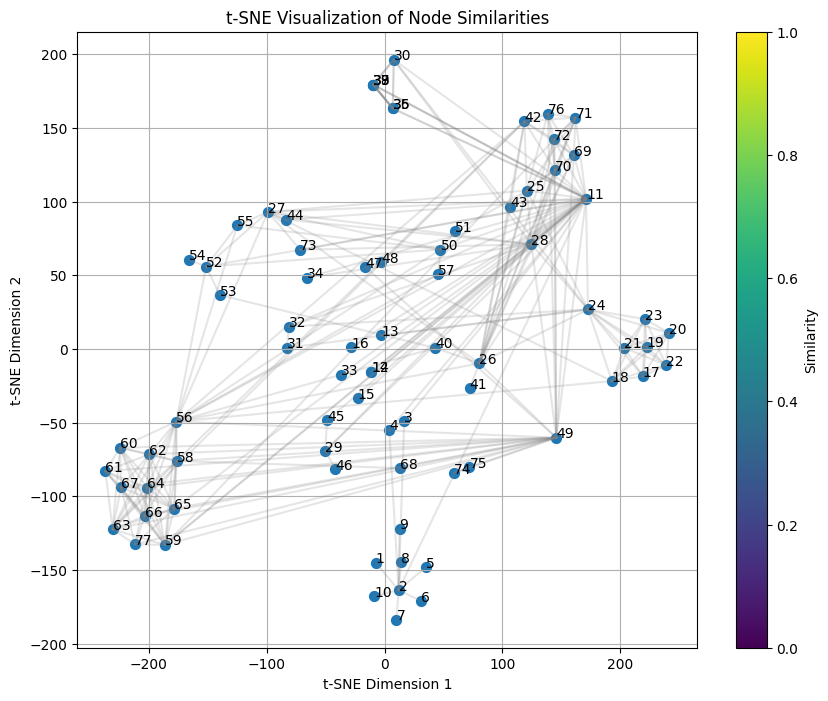

In [61]:
plot_tsne(similarities, node_list, edge_list, perplexity=10, learning_rate=250, n_iter=750, interactive=False)

# Jazz


In [62]:
nodes,edges,node_list,edge_list,weights = get_data_step6('Datasets/JazzNetwork.dot')

print(nodes) 
print(edges)
print(node_list)
print(edge_list)
print(weights)

[<pydot.core.Node object at 0x15f9f8410>, <pydot.core.Node object at 0x161947650>, <pydot.core.Node object at 0x1619344d0>, <pydot.core.Node object at 0x161935f10>, <pydot.core.Node object at 0x1619351d0>, <pydot.core.Node object at 0x161936cd0>, <pydot.core.Node object at 0x161937d10>, <pydot.core.Node object at 0x161940f90>, <pydot.core.Node object at 0x161942490>, <pydot.core.Node object at 0x161935190>, <pydot.core.Node object at 0x1619432d0>, <pydot.core.Node object at 0x16194dad0>, <pydot.core.Node object at 0x16194ec90>, <pydot.core.Node object at 0x16194f750>, <pydot.core.Node object at 0x1618d8690>, <pydot.core.Node object at 0x1618d95d0>, <pydot.core.Node object at 0x1618da350>, <pydot.core.Node object at 0x1618db150>, <pydot.core.Node object at 0x1618dba90>, <pydot.core.Node object at 0x15621ca50>, <pydot.core.Node object at 0x15621c550>, <pydot.core.Node object at 0x15621e790>, <pydot.core.Node object at 0x15621ed90>, <pydot.core.Node object at 0x15621cbd0>, <pydot.core.Nod

In [63]:
def compute_similarity_matrix(node_list, edge_list): #no wweights
    num_nodes = len(node_list)
    
    distances = np.full((num_nodes, num_nodes), np.inf)
    
    for u, v in edge_list:
        i = node_list.index(u)
        j = node_list.index(v)
        distances[i, j] = 1
        distances[j, i] = 1
    
    similarities = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                similarities[i, j] = 1 / (1 + distances[i, j])
    
    np.fill_diagonal(similarities, 1)
    
    return similarities

similarities = compute_similarity_matrix(node_list, edge_list)

print("Similarity matrix:")
print("\t" + "\t".join(node_list))
for i in range(len(node_list)):
    print(node_list[i], "\t", end="")
    for j in range(len(node_list)):
        print("{:.2f}".format(similarities[i, j]), "\t", end="")
    print()



Similarity matrix:
	1	10	11	12	13	14	15	16	17	18	19	2	20	21	22	23	24	3	4	5	6	7	8	9	120	121	122	123	124	125	67	130	145	146	147	148	149	150	157	159	160	101	112	128	133	137	152	164	165	166	167	168	169	170	171	172	173	174	177	178	179	153	155	100	102	103	104	105	106	107	108	109	110	111	116	117	118	119	127	138	139	140	154	191	26	27	28	48	54	55	74	75	76	80	81	83	84	85	86	87	89	90	92	93	95	96	97	98	91	94	134	192	114	158	88	187	188	189	56	135	176	193	126	131	132	31	25	115	144	62	113	35	70	29	30	32	33	143	78	79	141	142	161	180	183	184	34	36	37	42	50	51	52	53	58	60	61	64	65	66	68	69	72	156	181	190	196	38	39	40	41	43	44	45	46	47	57	59	63	71	73	49	185	186	129	136	82	99	151	194	197	182	77	163	198	175	162	195
1 	1.00 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 

Iteration 1: KL divergence = 0.3827400803565979
Iteration 2: KL divergence = 0.3827400803565979
Iteration 3: KL divergence = 0.3827400803565979
Iteration 4: KL divergence = 0.3827400803565979
Iteration 5: KL divergence = 0.3827400803565979
Iteration 6: KL divergence = 0.3827400803565979
Iteration 7: KL divergence = 0.3827400803565979
Iteration 8: KL divergence = 0.3827400803565979
Iteration 9: KL divergence = 0.3827400803565979
Iteration 10: KL divergence = 0.3827400803565979
Iteration 11: KL divergence = 0.3827400803565979
Iteration 12: KL divergence = 0.3827400803565979
Iteration 13: KL divergence = 0.3827400803565979
Iteration 14: KL divergence = 0.3827400803565979
Iteration 15: KL divergence = 0.3827400803565979
Iteration 16: KL divergence = 0.3827400803565979
Iteration 17: KL divergence = 0.3827400803565979
Iteration 18: KL divergence = 0.3827400803565979
Iteration 19: KL divergence = 0.3827400803565979
Iteration 20: KL divergence = 0.3827400803565979
Iteration 21: KL divergence =

/var/folders/pp/bdyt1jrd5w5d3twfkg227dtc0000gn/T/ipykernel_41076/3389298344.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='viridis', s=50)


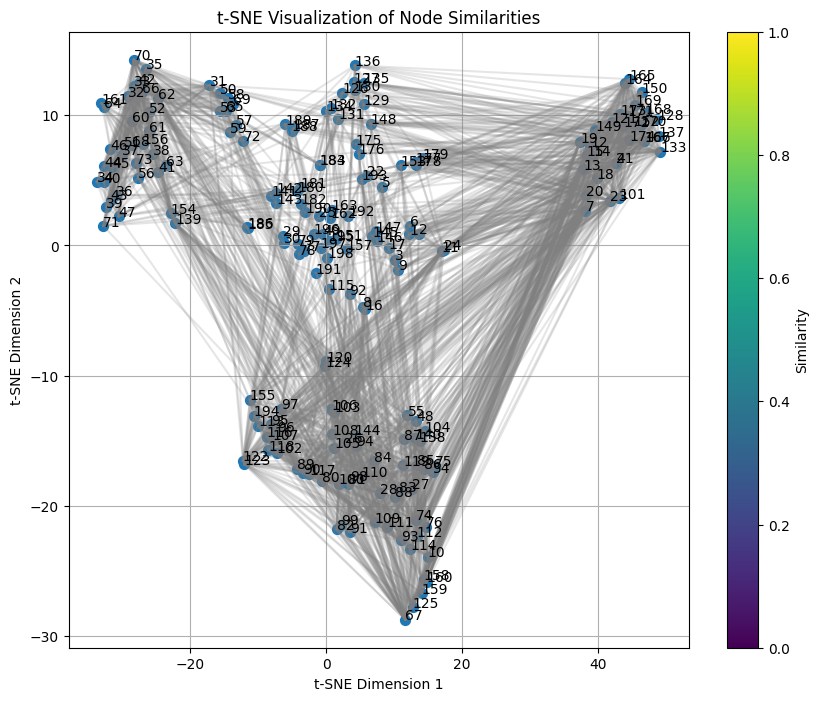

In [83]:
plot_tsne(similarities, node_list, edge_list, perplexity=15, learning_rate=250, n_iter=1500, interactive=False)

# League

In [84]:
nodes,edges,node_list,edge_list,weights = get_data_league('Datasets/LeagueNetwork.dot')

print(nodes) 
print(edges)
print(node_list)
print(edge_list)
print(weights)

[<pydot.core.Node object at 0x1665d9f50>, <pydot.core.Node object at 0x1665db550>, <pydot.core.Node object at 0x166632210>, <pydot.core.Node object at 0x1660e2a90>, <pydot.core.Node object at 0x1660e0d50>, <pydot.core.Node object at 0x1670a90d0>, <pydot.core.Node object at 0x166c41350>, <pydot.core.Node object at 0x166220890>, <pydot.core.Node object at 0x1615f1290>, <pydot.core.Node object at 0x166171810>, <pydot.core.Node object at 0x1619b6750>, <pydot.core.Node object at 0x166eb9890>, <pydot.core.Node object at 0x166c08350>, <pydot.core.Node object at 0x16709b2d0>, <pydot.core.Node object at 0x16680df10>, <pydot.core.Node object at 0x16160d9d0>]
[<pydot.core.Edge object at 0x1615cdfd0>, <pydot.core.Edge object at 0x1615cf910>, <pydot.core.Edge object at 0x1615cdcd0>, <pydot.core.Edge object at 0x166d99590>, <pydot.core.Edge object at 0x166d9b890>, <pydot.core.Edge object at 0x161973290>, <pydot.core.Edge object at 0x166184d90>, <pydot.core.Edge object at 0x1661851d0>, <pydot.core.Ed

In [87]:
def compute_similarity_matrix_league(node_list, edge_list, weights):
    edge_weights = {(u, v): weight for (u, v), weight in weights.items()}

    num_nodes = len(node_list)
    distances = np.zeros((num_nodes, num_nodes))
    
    for i, source in enumerate(node_list):
        for j, target in enumerate(node_list):
            if i != j:
                if (source, target) in edge_weights:
                    distances[i, j] = edge_weights[(source, target)]
                else:
                    distances[i, j] = -edge_weights[(target, source)] if (target, source) in edge_weights else np.inf

    similarities = np.zeros((num_nodes, num_nodes))
    for u, v in edge_list:
        i = node_list.index(u)
        j = node_list.index(v)
        similarities[i, j] = 1 / (1 + abs(distances[i, j])) if distances[i, j] != np.inf else 0 
        similarities[j, i] = similarities[i, j]  

    np.fill_diagonal(similarities, 1)  # Diagonal set to 1

    return similarities

similarities = compute_similarity_matrix_league(node_list, edge_list, weights)

print("Similarity matrix:")
print("\t" + "\t".join(node_list))
for i in range(len(node_list)):
    print(node_list[i], "\t", end="")
    for j in range(len(node_list)):
        print("{:.2f}".format(similarities[i, j]), "\t", end="")
    print()

Similarity matrix:
	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16
1 	1.00 	1.00 	0.33 	0.50 	0.50 	1.00 	0.50 	0.50 	0.25 	0.50 	0.33 	0.25 	0.50 	0.50 	0.50 	0.25 	
2 	1.00 	1.00 	0.50 	0.33 	0.25 	0.50 	0.33 	0.33 	0.50 	1.00 	0.50 	0.50 	0.50 	1.00 	0.33 	1.00 	
3 	0.33 	0.50 	1.00 	0.33 	0.50 	1.00 	1.00 	1.00 	1.00 	1.00 	0.33 	0.33 	0.50 	0.33 	1.00 	0.50 	
4 	0.50 	0.33 	0.33 	1.00 	0.14 	0.50 	0.25 	0.50 	0.33 	0.25 	0.50 	1.00 	1.00 	0.25 	0.20 	0.50 	
5 	0.50 	0.25 	0.50 	0.14 	1.00 	1.00 	0.33 	0.50 	1.00 	0.50 	0.50 	0.50 	0.50 	0.25 	0.20 	0.50 	
6 	1.00 	0.50 	1.00 	0.50 	1.00 	1.00 	0.50 	0.50 	0.25 	1.00 	0.50 	0.20 	0.33 	0.33 	0.50 	0.33 	
7 	0.50 	0.33 	1.00 	0.25 	0.33 	0.50 	1.00 	1.00 	0.25 	0.50 	1.00 	0.50 	1.00 	0.50 	0.25 	0.50 	
8 	0.50 	0.33 	1.00 	0.50 	0.50 	0.50 	1.00 	1.00 	1.00 	1.00 	0.50 	0.50 	0.50 	1.00 	1.00 	1.00 	
9 	0.25 	0.50 	1.00 	0.33 	1.00 	0.25 	0.25 	1.00 	1.00 	0.50 	0.50 	0.50 	0.50 	1.00 	1.00 	1.00 	
10 	0.50 	1.00 	1.00 	0.25 	0.50 	1.00 	0

Iteration 1: KL divergence = 0.1164347231388092
Iteration 2: KL divergence = 0.1164347231388092
Iteration 3: KL divergence = 0.1164347231388092
Iteration 4: KL divergence = 0.1164347231388092
Iteration 5: KL divergence = 0.1164347231388092
Iteration 6: KL divergence = 0.1164347231388092
Iteration 7: KL divergence = 0.1164347231388092
Iteration 8: KL divergence = 0.1164347231388092
Iteration 9: KL divergence = 0.1164347231388092
Iteration 10: KL divergence = 0.1164347231388092
Iteration 11: KL divergence = 0.1164347231388092
Iteration 12: KL divergence = 0.1164347231388092
Iteration 13: KL divergence = 0.1164347231388092
Iteration 14: KL divergence = 0.1164347231388092
Iteration 15: KL divergence = 0.1164347231388092
Iteration 16: KL divergence = 0.1164347231388092
Iteration 17: KL divergence = 0.1164347231388092
Iteration 18: KL divergence = 0.1164347231388092
Iteration 19: KL divergence = 0.1164347231388092
Iteration 20: KL divergence = 0.1164347231388092
Iteration 21: KL divergence =

/var/folders/pp/bdyt1jrd5w5d3twfkg227dtc0000gn/T/ipykernel_41076/3389298344.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='viridis', s=50)


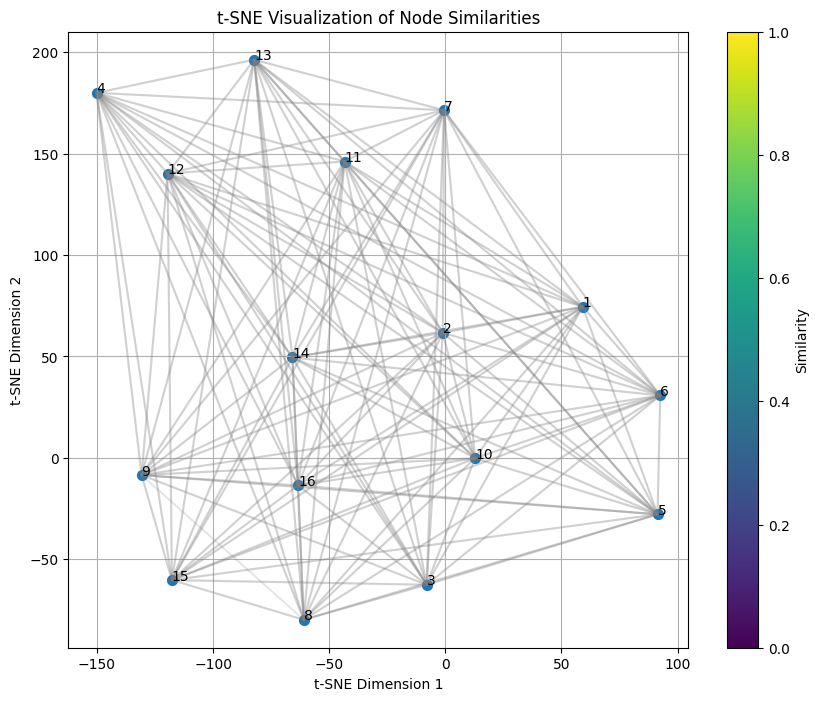

In [90]:
plot_tsne(similarities, node_list, edge_list, perplexity=10, learning_rate=200, n_iter=1000, interactive=False)